In [1]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Introduction

Soit $f$ une fonction donnée et le problème aux limites d'inconnue $u$

$$
\begin{align*}
    -\Delta u(x, y) &= f(x, y), && (x, y) \in \Omega = [0, L] \times [0, H] \\
    u(x, y)         &= 0,       && (x, y) \in \partial\Omega
\end{align*}
$$

On pose $h = L / (N + 1) = H / (M + 1)$.

## 1. Discrétisation par différences finies

### Maillage de $\Omega$

On fait une discrétisation en $x$ et en $y$

$$
\Delta x = \frac{L}{N + 1}, \quad \Delta y = \frac{H}{M + 1}, \Delta x = \Delta y = h
$$

$$
(x_i, y_j) = ((i + 1) h, (j + 1) h)
$$

Soit $g : \mathbb{R} \to \mathbb{R}$,

$$
g''(x) = \frac{g(x \Delta x) - 2 g(x) + g(x + \Delta x)}{(\Delta x)^2} + O\left((\Delta x)^2\right)
$$

$u_{i, j} \simeq u(x_i, y_j)$ et donc,

$$
\Delta u(x_i, y_j) \simeq \frac{u_{i + 1, j} - 2 u_{i, j} + u_{i - 1, j}}{(\Delta x)^2} + \frac{u_{i, j + 1} - 2 u_{i, j} + u_{i, j - 1}}{(\Delta y)^2}
$$

Si $0 \leqslant i \leqslant N - 1$ et $0 \leqslant j \leqslant M - 1$,

$$
-\Delta u(x_i, y_j) = \frac{4 u_{i, j} - u_{i + 1, j} - u_{i - 1, j} - u_{i, j + 1} - u_{i, j-1}}{h^2} = f(x_i, y_i) = f_{i, j} \tag{1}
$$

Sur les bords, $u_{i, j} = 0$, c'est à dire

$$
u_{-1, j} = u_{N, j} = 0 \quad \text{et} \quad u_{i, -1} = u_{i, M} = 0
$$

## 2. Forme Matricielle

Considérons une grille discrète bidimensionnelle de taille $N \times M$. Chaque point $(i, j)$ inconnu, où $(i, j) \in [0, N-1] \times [0, M-1]$, est représenté par la valeur $u_{i, j}$; sinon, s'il s'agit d'un point de bord, sa valeur est connue et égale à 0. Le nombre total d'inconnues est donné par $D = NM$. Pour résoudre ce problème, nous établissons un système d'équations linéaires représenté sous la forme matricielle suivante:

$$\boxed{AU = F} \quad A \in M_D(\mathbb{R})$$

Pour prendre en compte les valeurs aux bords, nous introduisons des inconnues fictives. La matrice $A$ aura une taille plus grande que le nombre d'inconnues réelles, donnée par $D = (N + 2)(M + 2)$, afin d'inclure les inconnues fictives pour les bords.

Pour transformer les deux indices $(i, j)$ en un seul indice, nous utilisons une fonction de numérotation qui associe un numéro unique à chaque inconnue. Une numérotation possible consiste à linéariser la grille en la parcourant de gauche à droite, de haut en bas. Ainsi, la numérotation pour un point $(i, j)$ serait donnée par :

$$k = (i + 1) + (j + 1)(N + 2)$$

Cela permet de convertir les indices $(i, j)$ en un seul indice utilisable pour appeler le solveur linéaire. $(i+1)$ représente le reste de la division euclidienne de $k$ par $(N+2)$, tandis que $(j+1)$ représente le quotient.

$$ U = \begin{pmatrix} v_0 \\ \vdots \\ v_{D - 1} \end{pmatrix} \quad \text{et} \quad F = \begin{pmatrix} f_0 \\ \vdots \\ f_{D - 1} \end{pmatrix} $$

Lorsque deux points $k$ et $l$ sont reliés par une arête de la grille, l'élément de la matrice $A$ correspondant, $A_{k,l}$, est égal à $- \frac{1}{h^2}$.

Lorsque $k = l$, l'élément de la matrice $A$ correspondant, $A_{k,l}$, est égal à $A_{k, k} = \frac{4}{h^2}$.

#### Traitement des conditions aux limites (*Méthode du grand pivot*)

Pour les points situés sur les bords de la grille, c'est-à-dire lorsque $i \in \{-1, N\}$ ou $j \in \{-1, M\}$, leur valeur est imposée à 0, c'est-à-dire $u_{i, j} = 0$. Pour prendre en compte ces conditions aux limites, nous imposons $v_k = 0$.

Pour cela, nous initialisons l'élément $A_{k, k}$ avec une valeur très grande (par exemple $10^{20}$) lors de la construction de la matrice. Cela nous permettra, lors de la résolution numérique, d'obtenir une valeur de $v_k$ très proche de 0, satisfaisant ainsi les conditions aux limites.

## 3. Programmation - Matrice $A$

Pour des raisons pratiques, nous utiliserons les indices $i' = i + 1$ et $j' = i + 1$. Ainsi,

$$
k = i' + j'(N+2), \; v_k = u_{i', j'} \simeq u(i' h, j' h) \; \text{et} \; f_k = f(x_{i'}, y_{j'}) = f(i' h, j' h)
$$

In [2]:
def compute_A(L, N, M):
    """
    Construit et renvoie une matrice creuse A pour le problème donné
    """
    # Liste des arêtes horizontales et verticales
    arêtes_horizontales = [(i + j * (N + 2), (i + 1) + j * (N + 2)) for i in range(N + 1) for j in range(M + 2)]
    arêtes_verticales = [(i + j * (N + 2), i + (j + 1) * (N + 2)) for i in range(N + 2) for j in range(M + 1)]
    arêtes = arêtes_horizontales + arêtes_verticales

    h = L / (N + 1)
    D = (N + 2) * (M + 2)

    # Initialisation des indices de lignes, colonnes et valeurs
    indices_lignes = []
    indices_colonnes = []
    valeurs = []

    # Remplissage des valeurs pour les arêtes hors diagonale
    for (k, l) in arêtes:
        indices_lignes.extend([l, k])
        indices_colonnes.extend([k, l])
        valeurs.extend([-1 / h / h, -1 / h / h])

    # Remplissage des valeurs pour la diagonale principale
    valeurs.extend([4 / h / h] * D)
    indices_lignes.extend(range(D))
    indices_colonnes.extend(range(D))

    # Valeurs infinies pour les bords de la grille
    valeurs.extend([np.inf] * 2 * (N + M + 4))

    # Indices pour les bords i' = 0 et i' = N + 1
    for j in range(M + 2):
        k = j * (N + 2)
        indices_lignes.extend([k, k + N + 1])
        indices_colonnes.extend([k, k + N + 1])
        
    # Indices pour les bords j' = 0 et j' = M + 1
    k = (M + 1) * (N + 2)
    for i in range(N + 2):
        indices_lignes.extend([i, i + k])
        indices_colonnes.extend([i, i + k])

    # Création de la matrice creuse
    matrice_A = csc_matrix((valeurs, (indices_lignes, indices_colonnes)), shape=(D, D))
    return matrice_A

# Exemple d'utilisation :
L = 1.0
N = 5
M = 4
matrice_A = compute_A(L, N, M)
print(matrice_A.toarray())

[[ inf -36.   0. ...   0.   0.   0.]
 [-36.  inf -36. ...   0.   0.   0.]
 [  0. -36.  inf ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  inf -36.   0.]
 [  0.   0.   0. ... -36.  inf -36.]
 [  0.   0.   0. ...   0. -36.  inf]]


## 4. Programmation - Résolution numérique

In [3]:
def compute_F(L, N, M, f):
    """
    Calcule et renvoie le vecteur F pour le problème discrétisé.
    """
    # Calcul des pas en x et y
    h = L / (N + 1)
    H = M * h

    def pt(k):
        """
        Calcule les coordonnées (x, y) à partir de l'indice k
        """
        i = k % (N + 2)
        j = k // (N + 2)
        x = i * h
        y = j * h
        return x, y

    F = [f(pt(k), L, H) for k in range((N + 2) * (M + 2))]
    return F

In [4]:
def u_plot(L, N, M, u):
    # Calcul de la taille de chaque pas en x
    h = L / N
    # Calcul de la taille totale en y
    H = (M + 1) * h
    
    # Création d'une liste 2D pour stocker les valeurs de u
    v = [[u[i + j * (N + 2)] for i in range(N + 2)] for j in range(M + 1, -1, -1)]

    # Affichage de la matrice v en tant qu'image
    plt.imshow(v, extent=(0, L, 0, H), interpolation='nearest')
    plt.show()

## 5. Validation du programme

Nous choisissons

$$
\begin{align*}
    u(x, y) &=
    \begin{cases}
        \frac{L^2 H^2}{\pi^2} \sin\left(\frac{\pi}{L} x\right) \sin\left(\frac{\pi}{L} y\right) \quad & \text{si } (x, y) \in [0, L] \times [0, H] \\
        0 & \text{sinon}
    \end{cases} \\
    f(x, y) &= (H^2 + L^2) \sin\left(\frac{\pi}{L} x\right) \sin\left(\frac{\pi}{L} y\right)
\end{align*}
$$

$$
u(0, \cdot) = u(\cdot, 0) = u(L, \cdot) = u(\cdot, H) = 0
$$

$u$ remplit donc les conditions au bord.

$$
\begin{align*}
    \frac{\partial^2 u}{\partial x^2}(x, y) &= -H^2 \sin\left(\frac{\pi}{L} x\right) \sin\left(\frac{\pi}{H} y\right) \\
    \frac{\partial^2 u}{\partial y^2}(x, y) &= -L^2 \sin\left(\frac{\pi}{L} x\right) \sin\left(\frac{\pi}{H} y\right)
\end{align*}
$$

et donc, $-\Delta u = f$.

In [5]:
def f(pt, L, H):
    """
    Calcule la valeur de la fonction source aux coordonnées pt.
    """
    x, y = pt
    return (L**2 + H**2) * np.sin(np.pi * x / L) * np.sin(np.pi * y / H)

In [6]:
def u_exact(pt, L, H):
    """
    Calcule la valeur exacte de la solution aux coordonnées pt.
    """
    x, y = pt
    return (H * L / np.pi)**2 * np.sin(np.pi * x / L) * np.sin(np.pi * y / H)

Erreur = 3.547905174938373e-07


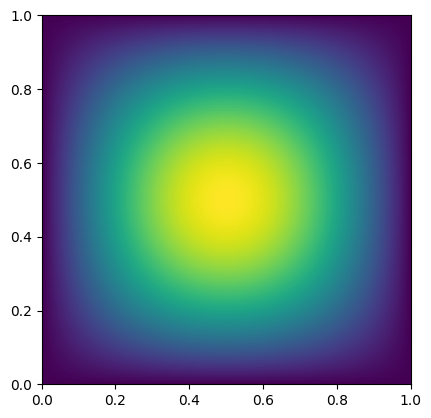

In [7]:
N = 500
M = 500
L = 1
h = L / (N + 1)

A = compute_A(L, N, M)
F = compute_F(L, N, M, f)

U = spsolve(A, F)
U_exact = compute_F(L, N, M, u_exact)

print('Erreur =', np.linalg.norm(U - U_exact) * h * h)

u_plot(L, N, M, U)

## 6. Stockage creux

Comparons les temps de calcul pour un cas avec $N = 10$ et $M = 1000$ puis $M = 10$ et $N = 1000$ avec le stockage creux ou plein.

Écrivons une fonction qui assemble une version pleine de $A$.

In [8]:
def compute_A_dense(L, N, M):
    """
    Construit et renvoie une matrice dense A pour le problème donné
    """
    h = L / (N + 1)
    D = (N + 2) * (M + 2)

    A = np.zeros((D, D))
    val = -1 / h / h

    # Remplissage des arêtes horizontales et verticales
    for i in range(N + 1):
        for j in range(M + 2):
            k = i + j * (N + 2)
            A[k, k + 1] = val
            A[k + 1, k] = val

    for i in range(N + 2):
        for j in range(M + 1):
            k = i + j * (N + 2)
            A[k, k + N + 2] = val
            A[k + N + 2, k] = val

    # Remplissage de la diagonale de A
    val = 4 / h / h
    for k in range(D):
        A[k, k] = val

    # Traitement des bords de la grille
    val = np.inf
    for j in range(M + 2):
        k = j * (N + 2)
        A[k, k] = val
        k += N + 1
        A[k, k] = val

    k = (M + 1) * (N + 2)
    for i in range(N + 2):
        A[i, i] = val
        A[i + k, i + k] = val

    return A

In [9]:
print('Temps de calcul:')
for (N, M) in [(1000, 10), (10, 1000)]:
    F = compute_F(L, N, M, f)
    print('N =', N, 'et M =', M)

    deb = time()
    A_sparse = compute_A(L, N, M)
    U = spsolve(A_sparse, F)
    print('\tavec matrice creuse : {0:2.4f}s'.format(time() - deb))

    deb = time()
    A_dense = compute_A_dense(L, N, M)
    U = np.linalg.solve(A_dense, F)
    print('\tavec matrice pleine : {0:2.2f}s'.format(time() - deb))

Temps de calcul:
N = 1000 et M = 10
	avec matrice creuse : 0.0250s
	avec matrice pleine : 5.60s
N = 10 et M = 1000
	avec matrice creuse : 0.0210s
	avec matrice pleine : 4.54s
